In [1]:
import pandas as pd
import numpy as np
import math
import time
import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt

import constant
import tools
from models import MLP, LSTM_Regression, train_model, timeseries_validation_training, Evaluation
import myplot
from features import Features

# 1. Load Files

In [2]:
# settlement = pd.read_parquet(constant.settlement_2018_path)
settlement = pd.read_parquet(constant.settlement_2018_path).append(pd.read_parquet(constant.settlement_2019_path))
dtype = {"GSRN":str,"Parent_GSRN":str,"Turbine_type":str,"BBR_municipal":str,"Placement":str,"grid":str}
windmill = pd.read_csv(constant.windmill_park_path, dtype=dtype)

wu10 = pd.read_parquet(constant.wu10_path)
wv10 = pd.read_parquet(constant.wv10_path)
wu100 = pd.read_parquet(constant.wu100_path)
wv100 = pd.read_parquet(constant.wv100_path)

ws10 = pd.read_parquet(constant.ws10_path)
ws100 = pd.read_parquet(constant.ws100_path)

tmp2 = pd.read_parquet(constant.tmp2_path)
tmp100 = pd.read_parquet(constant.tmp100_path)

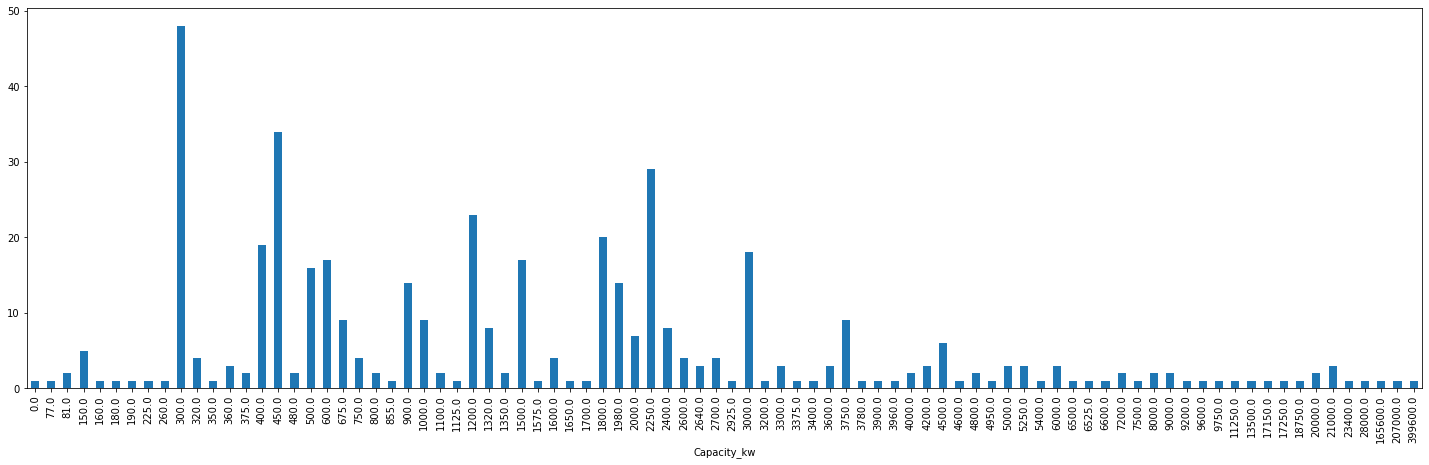

In [3]:
plt.figure(figsize=(25,7))
windmill.groupby("Capacity_kw").count()["GSRN"].plot.bar()

In [4]:
windmill[windmill["Capacity_kw"] == 3000]

,GSRN,BBR_municipal,Placement,Capacity_kw,Elevation,Slope,Aspect,grid,Roughness,Rotor_diameter_group,Navhub_height_group,Elevation_group,Slope_group,Aspect_group,Roughness_group,Navhub_height,Rotor_diameter
20,570715000000013317,851,LAND,3000.0,2.795000,2.176750,38.834,1163,0.10,"[44.0, 44.0, 44.0, 44.0]","[46.0, 46.0, 45.0, 46.5]","[2.8, 2.48, 2.9, 3.0]","[2.9939999999999998, 2.311, 1.515, 1.886999999...","[278.913, 279.151, 92.169, 154.9]","[0.1, 0.1, 0.1, 0.1]",45.875,44.00
41,570715000000019920,730,LAND,3000.0,48.972500,2.503750,308.060,1076,0.10,"[48.0, 48.0, 48.0, 48.0]","[45.0, 45.0, 45.0, 45.0]","[47.64, 54.4, 39.85, 54.0]","[5.004, 2.6069999999999998, 2.404, 0.0]","[265.151, 25.156999999999996, 132.75, -1.0]","[0.1, 0.1, 0.1, 0.1]",45.000,48.00
65,570715000000055218,420,LAND,3000.0,42.887500,4.250000,11.880,942,0.10,"[48.0, 48.0, 48.0, 48.0]","[50.0, 50.0, 50.0, 50.0]","[41.45, 40.1, 46.0, 44.0]","[9.565, 2.464, 3.707, 1.264]","[113.411, 115.34200000000001, 106.374, 118.8]","[0.1, 0.1, 0.1, 0.1]",50.000,48.00
120,570715000000013553,810,LAND,3000.0,7.632500,0.880500,-1.000,1122,0.10,"[44.0, 44.0, 44.0, 44.0]","[46.0, 46.0, 46.0, 46.0]","[7.0, 8.0, 7.647, 7.882999999999999]","[0.0, 0.863, 0.504, 2.155]","[-1.0, 42.887, 0.396, 269.60200000000003]","[0.1, 0.1, 0.1, 0.1]",46.000,44.00
170,570715000000019586,730,LAND,3000.0,51.772000,1.470800,149.416,1075,0.10,"[48.0, 48.0, 48.0, 48.0, 48.0]","[46.0, 46.0, 46.0, 45.0, 45.0]","[51.0, 53.0, 52.0, 51.86, 51.0]","[1.669, 2.449, 0.496, 2.5269999999999997, 0.213]","[264.318, 234.543, 153.84, 319.175, 46.46]","[0.1, 0.1, 0.1, 0.1, 0.1]",45.600,48.00
176,570715000000022630,707,LAND,3000.0,18.330400,1.459800,142.181,991,0.18,"[43.0, 43.0, 43.0, 43.0, 43.0]","[46.0, 46.0, 46.0, 46.0, 46.0]","[20.651999999999997, 18.0, 17.0, 19.0, 17.0]","[2.917, 2.49, 0.0, 1.068, 0.8240000000000001]","[159.179, 58.473, -1.0, 245.72, 138.585]","[0.3, 0.1, 0.1, 0.3, 0.1]",46.000,43.00
197,570715000000038549,665,LAND,3000.0,8.800000,0.124400,-1.000,1325,0.10,"[43.0, 43.0, 43.0, 43.0, 43.0]","[46.0, 46.0, 46.0, 46.0, 46.0]","[9.0, 9.0, 9.0, 9.0, 8.0]","[0.0, 0.0, 0.0, 0.0, 0.622]","[-1.0, -1.0, -1.0, -1.0, 73.454]","[0.1, 0.1, 0.1, 0.1, 0.1]",46.000,43.00
229,570715000000038426,665,LAND,3000.0,7.984200,0.843800,-1.000,1325,0.14,"[44.0, 44.0, 44.0, 44.0, 44.0]","[45.0, 45.0, 45.0, 45.0, 45.0]","[9.0, 6.0, 8.0, 7.0, 9.921]","[0.0, 1.413, 1.083, 1.61, 0.113]","[-1.0, 98.38, 186.804, 150.092, 18.05700000000...","[0.1, 0.1, 0.1, 0.1, 0.3]",45.000,44.00
231,570715000000022999,741,LAND,3000.0,11.730333,1.594333,-0.236,946,0.10,"[54.0, 54.0, 54.0]","[50.0, 50.0, 50.0]","[12.0, 12.190999999999999, 11.0]","[0.899, 2.404, 1.48]","[120.74700000000001, 315.0, -0.483]","[0.1, 0.1, 0.1]",50.000,54.00
255,570715000000019470,730,LAND,3000.0,37.324000,1.210200,161.213,1075,0.10,"[43.0, 43.0, 43.0, 43.0, 43.0]","[46.0, 46.0, 46.0, 46.0, 46.0]","[38.0, 40.62, 30.0, 43.0, 35.0]","[0.94, 1.5490000000000002, 2.432, 0.605, 0.525]","[62.023, 141.343, 145.584, 21.65, 33.725]","[0.1, 0.1, 0.1, 0.1, 0.1]",46.000,43.00


In [5]:
windmill = windmill[windmill["GSRN"] == "570715000000064494"]

In [ ]:
windmill["Elevation_group"] = windmill["Elevation_group"].apply(lambda x: np.array(x[1:-1].split(", ")).astype(float))
windmill["Slope_group"] = windmill["Slope_group"].apply(lambda x: np.array(x[1:-1].split(", ")).astype(float))
windmill["Aspect_group"] = windmill["Aspect_group"].apply(lambda x: np.array(x[1:-1].split(", ")).astype(float))
windmill["Roughness_group"] = windmill["Roughness_group"].apply(lambda x: np.array(x[1:-1].split(", ")).astype(float))

In [ ]:
def flatten_features(df, name, newname):
    for x in df[name]:
        for i in range(len(x)):
            df[newname +"_"+ str(i)] = x[i]
    return df

In [ ]:
windmill = flatten_features(windmill, "Elevation_group", "Elevation")
windmill = flatten_features(windmill, "Slope_group", "Slope")
windmill = flatten_features(windmill, "Aspect_group", "Aspect")
windmill = flatten_features(windmill, "Roughness_group", "Roughness")

In [ ]:
windmill.columns

In [ ]:
windmill = windmill.drop(columns=['BBR_municipal', 'Placement', 'Rotor_diameter_group',
       'Navhub_height_group', 'Elevation_group', 'Slope_group', 'Aspect_group',
       'Roughness_group'])

### Aggregate windmill and settlement

In [6]:
df = pd.merge(windmill, settlement, on="GSRN")

# 2. Feature Extraction
## Extract Weather Data
Register grided weather data extration functions

In [7]:
feat_tool = Features(wu10, wv10, wu100, wv100, tmp2, tmp100)
df = feat_tool.extract(df)

193.89035296440125


In [15]:
cols_filter = ["grid", "month", "hour", "GSRN", "Placement", "Rotor_diameter", "Navhub_height", "Elevation", "Roughness", "BBR_municipal", 'Capacity_kw', 'Slope', 'Aspect','Rotor_diameter_group','Navhub_height_group', 'Elevation_group', 'Slope_group','Aspect_group', 'Roughness_group',]

In [13]:
cols = [x for x in df.columns if x not in cols_filter + ['TIME_CET',"predicted_ahead"]]
df[cols] = tools.normalize_maxmin(df[cols]).fillna(0)

In [16]:
df = df.drop(columns=cols_filter)

In [17]:
df["TIME_CET"] = pd.to_datetime(df["TIME_CET"])

In [18]:
date_s = pd.to_datetime("2019-12-05")
date_e = pd.to_datetime("2019-12-11")

df_train = df[df["TIME_CET"] < date_s]
df_test = df[df["TIME_CET"] >= date_s][df["TIME_CET"] < date_e]

# Prediction NN - Geo Free# Prediction NN - Geo Free

In [20]:
cols = ['hws_u_wsr','hws_v_wsr','hws_uv_wsr','hws_uv_wsr^2','hws_uv_wsr^3','htmp_exp',
'hws_uv_wsr_q0.1','hws_uv_wsr_q0.3','hws_uv_wsr_q0.5','hws_uv_wsr_q0.7','hws_uv_wsr_q0.9',
'm1', 'm2', 'm3', 'm4', 'm5', 'm6', 'm7', 'm8', 'm9', 'm10', 'm11', 'm12',
'h0', 'h1', 'h2', 'h3', 'h4', 'h5', 'h6', 'h7', 'h8', 'h9', 'h10', 'h11', 'h12', 'h13', 'h14', 'h15', 'h16', 'h17', 'h18', 'h19', 'h20', 'h21', 'h22', 'h23']

In [21]:
model_geofree = MLP(
  input_size=47,
  hidden_size=1000,
  output_size=1
)
model_geofree, train_hist_geofree, test_hist_geofree = timeseries_validation_training(df=df_train, features=cols, target=["VAERDI"], n_groups=6, model=model_geofree, lr=0.001, num_epochs=30)

Epoch 0 train loss: 0.012289122678339481 test loss: 0.04282420501112938
Epoch 10 train loss: 0.004427236970514059 test loss: 0.015118125826120377
Epoch 20 train loss: 0.004003029316663742 test loss: 0.013963580131530762
Epoch 29 train loss: 0.0036657557357102633 test loss: 0.01348815020173788
Epoch 0 train loss: 0.008448525331914425 test loss: 0.015637200325727463
Epoch 10 train loss: 0.007191954646259546 test loss: 0.012210446409881115
Epoch 20 train loss: 0.00679792370647192 test loss: 0.012297949753701687
Epoch 29 train loss: 0.006622459273785353 test loss: 0.012474948540329933
Epoch 0 train loss: 0.008533302694559097 test loss: 0.015718456357717514
Epoch 10 train loss: 0.008445153944194317 test loss: 0.01722882129251957
Epoch 20 train loss: 0.008163920603692532 test loss: 0.015807365998625755
Epoch 29 train loss: 0.008098135702311993 test loss: 0.015915485098958015
Epoch 0 train loss: 0.010041668079793453 test loss: 0.006827602628618479
Epoch 10 train loss: 0.009234520606696606 tes

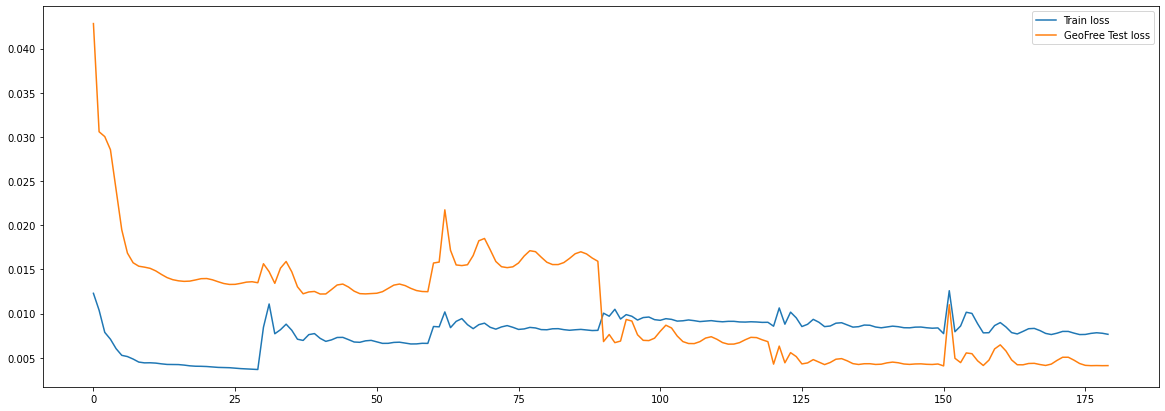

In [22]:
myplot.Model_Loss({"Train loss":train_hist_geofree, "GeoFree Test loss": test_hist_geofree})

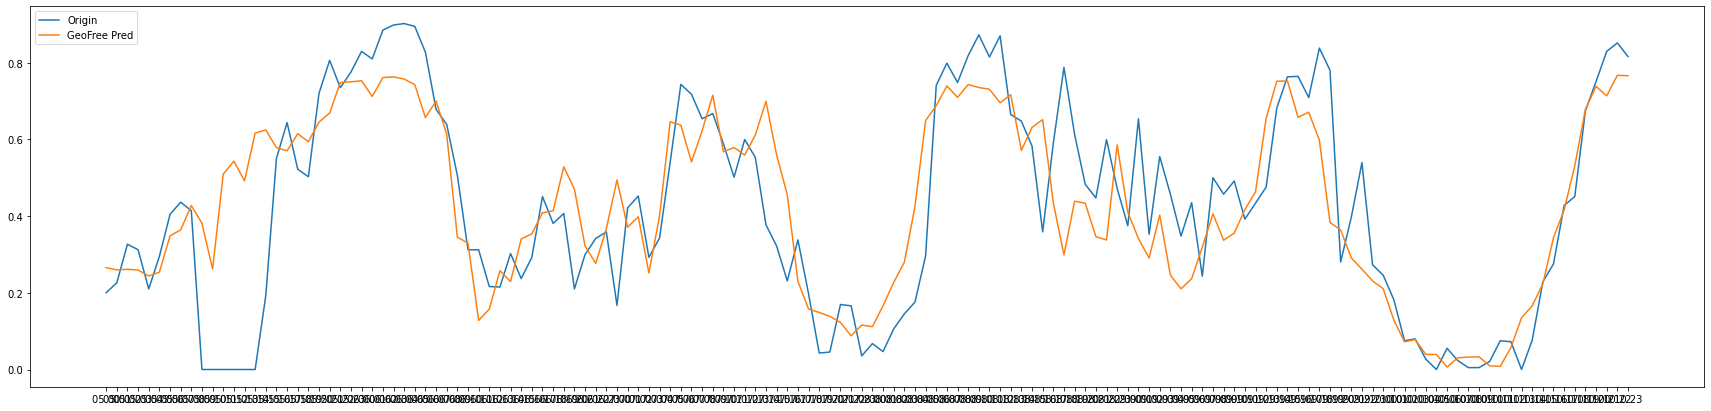

In [23]:
df_test["TIME_CET"] = df_test["TIME_CET"].apply(str)
df_test = df_test.sort_values(["TIME_CET"])
x_test_tensor = torch.tensor(df_test[cols].values, dtype = torch.float)
y_pred_tensor = model_geofree(x_test_tensor)
df_test["pred"] = y_pred_tensor.detach().flatten().numpy()
myplot.timelines_plot(df_test["TIME_CET"], {"Origin": df_test["VAERDI"], "GeoFree Pred":df_test["pred"]})

In [30]:
df_test

,VAERDI,TIME_CET,predicted_ahead,wu10,wv10,wu100,wv100,wsr_u,wsr_v,hws_u_rn,...,h15,h16,h17,h18,h19,h20,h21,h22,h23,pred
16849,0.200246,2019-12-05 00:00:00,1,0.563319,0.647626,0.563319,0.647626,1.0,1.0,0.563319,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.253246
16850,0.226044,2019-12-05 01:00:00,2,0.573616,0.646545,0.573616,0.646545,1.0,1.0,0.573616,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.251247
16851,0.326781,2019-12-05 02:00:00,3,0.570376,0.658186,0.570376,0.658186,1.0,1.0,0.570376,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.254528
16852,0.312039,2019-12-05 03:00:00,1,0.524371,0.699634,0.524371,0.699634,1.0,1.0,0.524371,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.245580
16853,0.210074,2019-12-05 04:00:00,2,0.545658,0.697680,0.545658,0.697680,1.0,1.0,0.545658,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.251896
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16988,0.674447,2019-12-10 19:00:00,2,0.434907,0.916521,0.434907,0.916521,1.0,1.0,0.434907,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.667448
16989,0.750614,2019-12-10 20:00:00,3,0.444277,0.953230,0.444277,0.953230,1.0,1.0,0.444277,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.744268
16990,0.829238,2019-12-10 21:00:00,4,0.464600,0.946579,0.464600,0.946579,1.0,1.0,0.464600,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.700267
16991,0.851351,2019-12-10 22:00:00,5,0.480333,0.956515,0.480333,0.956515,1.0,1.0,0.480333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.759739


### Evaluation by test
BIAS, MAE, MSE, RMSE

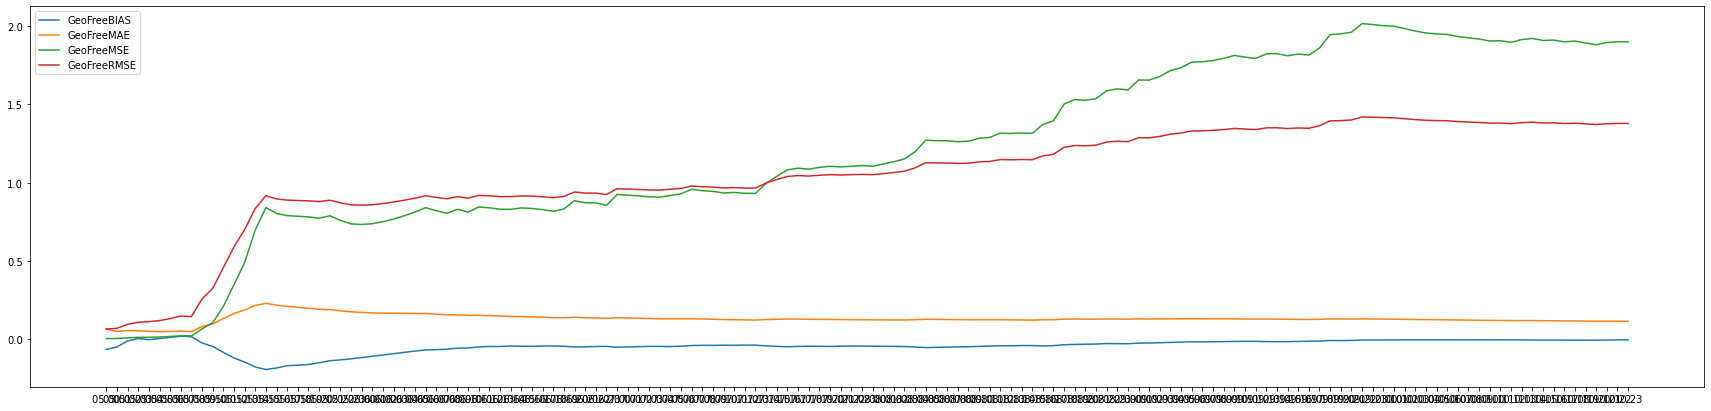

BIAS:  -0.003938719280232681
MAE:  0.11484340323198697
MSE:  1.8992170462902846
RMSE:  1.3781208387838435
R^2 Score:  0.6221592253990194


In [24]:
df_evl = Evaluation(df_test[["TIME_CET", "VAERDI", "pred"]], "GeoFree")
print("BIAS: ", df_evl["GeoFree_BIAS"].iloc[-1])
print("MAE: ", df_evl["GeoFree_MAE"].iloc[-1])
print("MSE: ", df_evl["GeoFree_MSE"].iloc[-1])
print("RMSE: ", df_evl["GeoFree_RMSE"].iloc[-1])
print("R^2 Score: ", df_evl["GeoFree_R^2"].iloc[-1])

# Prediction NN - Geo

In [25]:
cols = ['hws_u_rn','hws_v_rn','hws_uv_rn','hws_uv_rn^2','hws_uv_rn^3','htmp_exp',
'hws_uv_rn_q0.1','hws_uv_rn_q0.3','hws_uv_rn_q0.5','hws_uv_rn_q0.7','hws_uv_rn_q0.9',
'm1', 'm2', 'm3', 'm4', 'm5', 'm6', 'm7', 'm8', 'm9', 'm10', 'm11', 'm12',
'h0', 'h1', 'h2', 'h3', 'h4', 'h5', 'h6', 'h7', 'h8', 'h9', 'h10', 'h11', 'h12', 'h13', 'h14', 'h15', 'h16', 'h17', 'h18', 'h19', 'h20', 'h21', 'h22', 'h23']

In [26]:
model_geo = MLP(
  input_size=47,
  hidden_size=1000,
  output_size=1
)
model_geo, train_hist_geo, test_hist_geo = timeseries_validation_training(df=df_train, features=cols, target=["VAERDI"], n_groups=6, model=model_geo, lr=0.001, num_epochs=30)

Epoch 0 train loss: 0.015159301459789276 test loss: 0.048646923154592514
Epoch 10 train loss: 0.004704127088189125 test loss: 0.0158059224486351
Epoch 20 train loss: 0.003966768737882376 test loss: 0.015077151358127594
Epoch 29 train loss: 0.0037531540729105473 test loss: 0.01477159932255745
Epoch 0 train loss: 0.009141720831394196 test loss: 0.01844632439315319
Epoch 10 train loss: 0.0073553347028791904 test loss: 0.013255627825856209
Epoch 20 train loss: 0.007026079576462507 test loss: 0.012780236080288887
Epoch 29 train loss: 0.006742589175701141 test loss: 0.012927021831274033
Epoch 0 train loss: 0.008774279616773129 test loss: 0.01603682152926922
Epoch 10 train loss: 0.008538465015590191 test loss: 0.01741056889295578
Epoch 20 train loss: 0.008430972695350647 test loss: 0.016878541558980942
Epoch 29 train loss: 0.008223147131502628 test loss: 0.016673846170306206
Epoch 0 train loss: 0.010267025791108608 test loss: 0.008108311332762241
Epoch 10 train loss: 0.009421072900295258 test

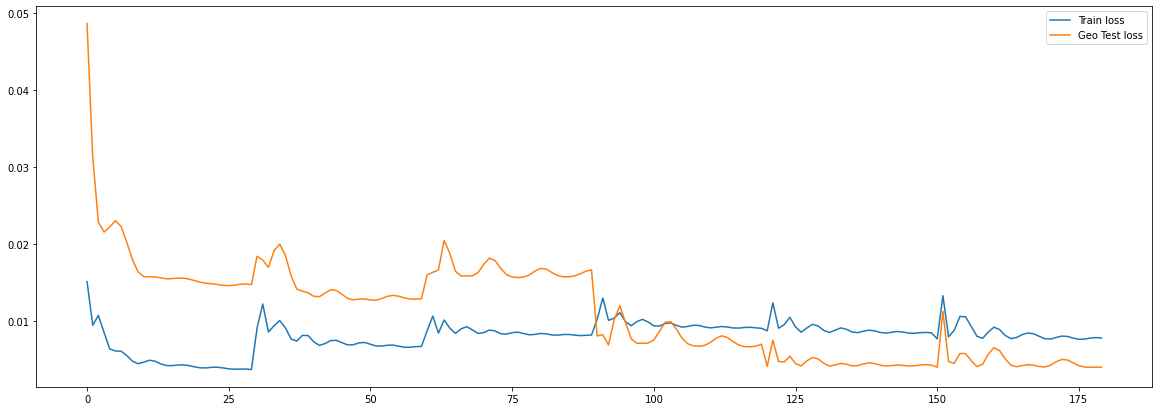

In [27]:
myplot.Model_Loss({"Train loss":train_hist_geo, "Geo Test loss": test_hist_geo})

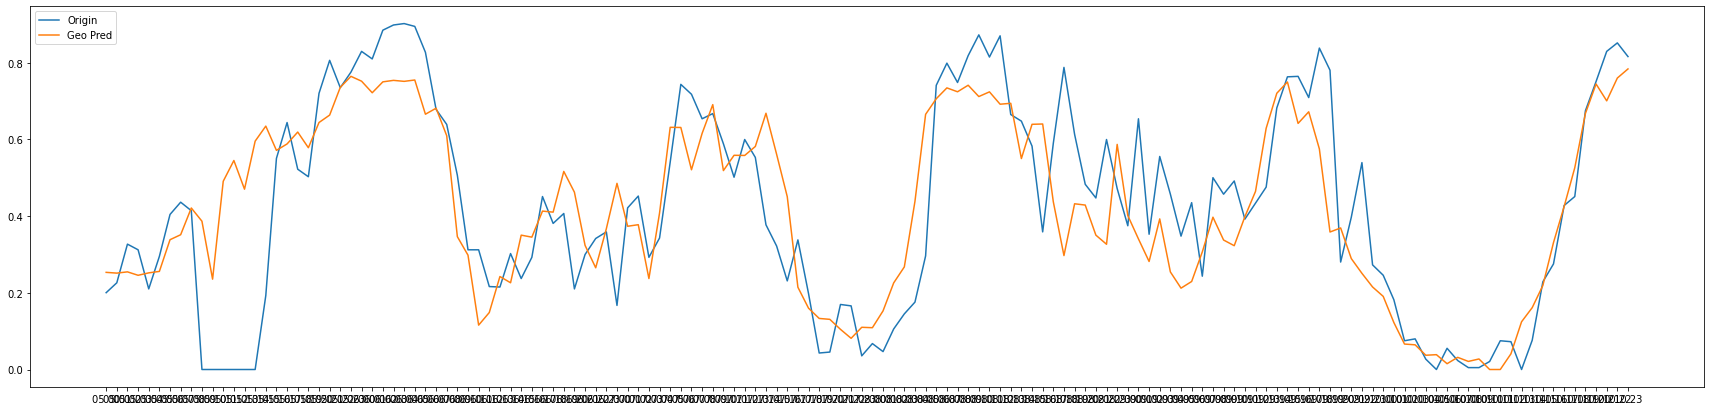

In [28]:
df_test = df_test.sort_values(["TIME_CET"])
df_test["TIME_CET"] = df_test["TIME_CET"].apply(str)
x_test_tensor = torch.tensor(df_test[cols].values, dtype = torch.float)
y_pred_tensor = model_geo(x_test_tensor)
df_test["pred"] = y_pred_tensor.detach().flatten().numpy()
myplot.timelines_plot(df_test["TIME_CET"], {"Origin": df_test["VAERDI"], "Geo Pred":df_test["pred"]})

### Evaluation

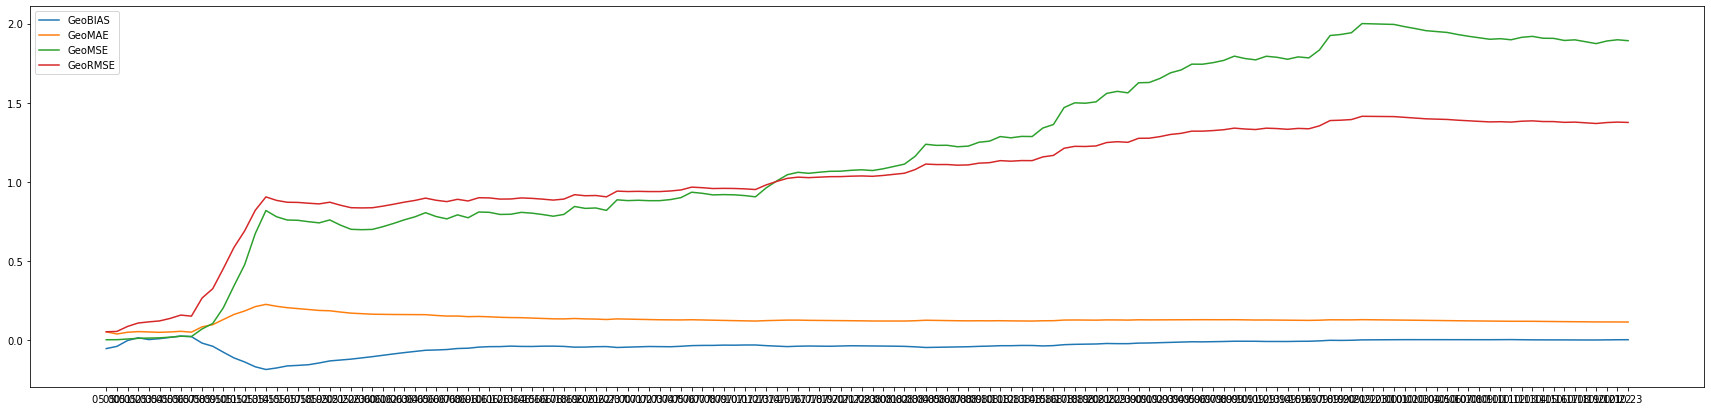

BIAS:  0.003018575643641556
MAE:  0.11461750365069852
MSE:  1.8917527886089762
RMSE:  1.3754100438083823
R^2 Score:  0.622994453919412


In [29]:
df_evl = Evaluation(df_test[["TIME_CET", "VAERDI", "pred"]], "Geo")
print("BIAS: ", df_evl["Geo_BIAS"].iloc[-1])
print("MAE: ", df_evl["Geo_MAE"].iloc[-1])
print("MSE: ", df_evl["Geo_MSE"].iloc[-1])
print("RMSE: ", df_evl["Geo_RMSE"].iloc[-1])
print("R^2 Score: ", df_evl["Geo_R^2"].iloc[-1])